In [1]:
import pandas as pd
import numpy as np
import preprocessing
import metrics_experiment
from sklearn.metrics import auc
import metrics_helper
from datetime import timedelta
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
# Permanently changes the pandas settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Preprocesing

In [2]:
dxcm_1006 = pd.read_excel('../tests/test-data/dexcom-data/1006_baseline.xlsx')

In [3]:
example1 = pd.read_csv('../tests/test-data/libre-data/3028 2.csv', header=None)
example2 = pd.read_csv('../tests/test-data/libre-data/3028 2.csv')


In [5]:
example3 = pd.read_csv('../tests/test-data/libre-test.csv', header=2)
example3 = example3[['Device Timestamp','Historic Glucose mmol/L']]
example3.columns = ['time', 'glc']
example3.time = pd.to_datetime(example3.time)
example3 = example3.dropna()

In [4]:
preprocessed_objects = []
for i in [example1, example2]:
    preprocessed_objects.append(preprocessing.preprocess_df(i, '3028 2.csv'))

c:\Users\cr591\OneDrive - University of Exeter\Desktop\PhD\Projects\diametrics-webapp-dash\code\transformData.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=[2], inplace=True)


In [131]:
df = pd.DataFrame.from_dict(preprocessed_objects[0]['data'])

In [27]:
total_df = pd.DataFrame()
for i in preprocessed_objects:
    if i.usable==True:
        df_id = i.data
        df_id['ID'] = i.id
        total_df = total_df.append(i.data)

AttributeError: 'dict' object has no attribute 'usable'

In [10]:
results = []
results.append(metrics_experiment.calculate_all_metrics(df, ID='1', interval=15))
results.append(metrics_experiment.calculate_all_metrics(example3, ID='2', interval=15))


c:\Users\cr591\OneDrive - University of Exeter\Desktop\PhD\Projects\diametrics-webapp-dash\code\metrics_helper.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_indexes.sort_values('time', inplace=True)
c:\Users\cr591\OneDrive - University of Exeter\Desktop\PhD\Projects\diametrics-webapp-dash\code\metrics_helper.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_indexes['diff'] = single_indexes['glc'].diff()
c:\Users\cr591\OneDrive - University of Exeter\Desktop\PhD\Projects\diametrics-webapp-dash\code\metrics_helper.py:251: SettingWithCopyWarn

In [11]:
metrics = pd.DataFrame.from_dict(results)

## Time stuff

In [9]:
def get_day_night_breakdown(df, start, end):
    df_dt = df.set_index('time')
    day = df_dt.between_time(start, end)
    night = df_dt[~df_dt.index.isin(day.index)].reset_index()
    day = day.reset_index()
    return day, night

In [7]:
example3.head()
df = example3

In [15]:
day, night = get_day_night_breakdown(df, '06:00','01:00')

In [16]:
day

,time,glc
0,2020-10-01 13:16:00,2.7
1,2020-10-01 13:31:00,3.0
2,2020-10-01 13:46:00,3.7
3,2020-10-01 14:01:00,3.3
4,2020-10-01 14:16:00,2.9
5,2020-10-01 14:31:00,2.6
6,2020-10-01 14:46:00,2.3
7,2020-10-01 15:01:00,2.2
8,2020-10-01 15:16:00,2.2
9,2020-10-01 15:31:00,2.2


## Cooler boxplots

In [88]:
metrics

,ID,Average glucose,SD,CV,eA1c,Min. glucose,Max. glucose,AUC,LBGI,HBGI,MAGE,TIR normal,TIR hypoglycemia,TIR level 1 hypoglycemia,TIR level 2 hypoglycemia,TIR hyperglycemia,TIR level 1 hyperglycemia,TIR level 2 hyperglycemia,Total hypogylcemic episodes,Level 1 hypogylcemic episodes,Level 2 hypogylcemic episodes,Average length of hypoglycemic episodes,Total time in hypoglycemia
0,1,8.498440,3.667772,43.158179,6.973862,2.2,27.8,6.288762,2.979954,6.997627,8.32570,55.81,11.11,4.98,6.13,33.07,25.37,7.71,258,105,153,0 days 07:30:21,80 days 16:29:00
1,2,4.309789,1.149454,26.670781,4.339490,2.2,8.8,3.224623,8.164737,0.034349,2.97854,61.07,38.93,28.77,10.17,0.00,0.00,0.00,49,30,19,5 days 20:05:31,286 days 00:30:00


In [39]:
options = list(metrics.columns)
to_remove = ['ID', 'Min. glucose', 'Max. glucose', 'TIR normal',
 'TIR hypoglycemia',
 'TIR level 1 hypoglycemia',
 'TIR level 2 hypoglycemia',
 'TIR hyperglycemia',
 'TIR level 1 hyperglycemia',
 'TIR level 2 hyperglycemia',
 'Total hypogylcemic episodes',
 'Level 1 hypogylcemic episodes',
 'Level 2 hypogylcemic episodes',
 'Average length of hypoglycemic episodes',
 'Total time in hypoglycemia',
 'LBGI',
 'HBGI',]
options = [i for i in options if i not in to_remove]
options = options+['Time in range', 'Hypoglycemic episodes', 'LGBI/HGBI']


In [40]:
options

['Average glucose',
 'SD',
 'CV',
 'eA1c',
 'AUC',
 'MAGE',
 'Time in range',
 'Hypoglycemic episodes',
 'LGBI/HGBI']

In [97]:
px.box(metrics, y=['TIR hypoglycemia', 'TIR normal', 'TIR hyperglycemia'])

In [91]:
px.bar(metrics, x='ID', y=['TIR level 2 hypoglycemia', 'TIR level 1 hypoglycemia', 'TIR normal', 'TIR level 1 hyperglycemia', 'TIR level 2 hyperglycemia'])

In [90]:
px.bar(metrics, x='ID', y=['TIR hypoglycemia', 'TIR normal', 'TIR hyperglycemia'])

## Periodic analysis

In [133]:
periodic_data = pd.read_excel('example_periodic.xlsx')
periodic_data.groupby('label')

In [145]:
dxcm_1006

,Id,SerialNumber,IsDataBlinded,IsKeepPrivate,InternalTime,DisplayTime,Value,InternalTime2,DisplayTime3,Value4,EventMarkers
0,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-09 21:20:45,2018-01-09 13:20:45,13.60,NaN,NaN,NaN,NaN
1,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-09 21:22:10,2018-01-09 13:22:10,12.82,NaN,NaN,NaN,NaN
2,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-09 21:34:08,2018-01-09 13:34:08,14.98,NaN,NaN,NaN,NaN
3,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-09 21:35:40,2018-01-09 13:35:40,15.32,NaN,NaN,NaN,NaN
4,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-10 03:32:45,2018-01-09 19:32:45,13.60,NaN,NaN,NaN,NaN
5,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-10 15:32:39,2018-01-10 07:32:39,6.33,NaN,NaN,NaN,NaN
6,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-11 04:43:37,2018-01-10 20:43:37,11.99,NaN,NaN,NaN,NaN
7,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-11 15:35:16,2018-01-11 07:35:16,13.49,NaN,NaN,NaN,NaN
8,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-12 03:15:03,2018-01-11 19:15:03,10.32,NaN,NaN,NaN,NaN
9,{FE408A03-0EBC-4671-A914-534ECE4DFFAC},SM70600726,0,1,2018-01-12 15:20:48,2018-01-12 07:20:48,5.11,NaN,NaN,NaN,NaN


In [156]:
df = dxcm_1006[['InternalTime2', 'Value4']]
df.columns = ['time', 'glc']
df.glc = df.glc.replace({'Low':2.2})
df.glc = df.glc.astype(float)
df.sort_values('time', inplace=True)

C:\Users\cr591\AppData\Local\Temp\ipykernel_25456\2759986661.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cr591\AppData\Local\Temp\ipykernel_25456\2759986661.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cr591\AppData\Local\Temp\ipykernel_25456\2759986661.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [173]:
exercise = periodic_data.loc[periodic_data.label=='Exercise']
exercise.startDateTime = pd.to_datetime(exercise.startDateTime)
exercise.endDateTime = pd.to_datetime(exercise.endDateTime)

meal = periodic_data.loc[periodic_data.label=='Meal']

C:\Users\cr591\AppData\Local\Temp\ipykernel_25456\2395110499.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cr591\AppData\Local\Temp\ipykernel_25456\2395110499.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [167]:
meal

,ID,startDateTime,endDateTime,label
4,1006_baseline,2018-01-10 09:00:00.000,2018-01-10 09:30:00.000,Meal
5,1006_baseline,2018-01-11 09:00:00.000,2018-01-11 09:30:00.000,Meal
6,1006_baseline,2018-01-12 09:00:00.000,2018-01-12 09:30:00.000,Meal
7,1006_baseline,2018-01-13 09:00:00.000,2018-01-13 09:30:00.000,Meal
8,1006_baseline,2018-01-14 09:00:00.000,2018-01-14 09:30:00.000,Meal
9,1006_baseline,2018-01-15 09:00:00.000,2018-01-15 09:30:00.000,Meal
10,1006_baseline,2018-01-16 09:00:00.000,2018-01-16 09:30:00.000,Meal
11,1006_baseline,2018-01-10 12:59:59.995,2018-01-10 13:30:00.000,Meal
12,1006_baseline,2018-01-11 12:59:59.995,2018-01-11 13:30:00.000,Meal
13,1006_baseline,2018-01-12 12:59:59.995,2018-01-12 13:30:00.000,Meal


In [162]:
exercise

,ID,startDateTime,endDateTime,label
0,1006_baseline,2018-01-10 18:00:00,2018-01-10 19:30:00,Exercise
1,1006_baseline,2018-01-12 19:00:00,2018-01-12 20:00:00,Exercise
2,1006_baseline,2018-01-15 10:00:00,2018-01-15 12:00:00,Exercise
3,1006_baseline,2018-01-16 11:00:00,2018-01-16 11:45:00,Exercise


In [191]:
#fig = px.line( line_color='black')
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=df.time, y=df.glc,
                         line=dict(color='black', ), opacity=0.5, showlegend=False, name='Glucose trace'),
                         #row=1, col=1
                         )

for i, row in exercise.iterrows():
    start = row.startDateTime
    end = row.endDateTime

    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="blue", opacity=0.4,
        layer="below", line_width=0,
        #row=1, col=1
    ),
    fig.add_vrect(
        x0=end, x1=end+datetime.timedelta(minutes=60),
        fillcolor="blue", opacity=0.3,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
    fig.add_vrect(
        x0=end+datetime.timedelta(minutes=60), x1=end+datetime.timedelta(minutes=120),
        fillcolor="blue", opacity=0.2,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
    fig.add_vrect(
        x0=end+datetime.timedelta(minutes=120), x1=end+datetime.timedelta(minutes=180),
        fillcolor="blue", opacity=0.1,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
'''for i, row in meal.iterrows():
    start = row.startDateTime
    end = row.endDateTime
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="orange", opacity=0.3,
        layer="below", line_width=0,
        #row=1, col=1
    ),'''
fig.show()

In [192]:
#fig = px.line( line_color='black')
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=df.time, y=df.glc,
                         line=dict(color='black', ), opacity=0.5, showlegend=False, name='Glucose trace'),
                         #row=1, col=1
                         )
    
for i, row in meal.iterrows():
    start = row.startDateTime
    end = row.endDateTime
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="orange", opacity=0.4,
        layer="below", line_width=0,
        #row=1, col=1
    ),
    fig.add_vrect(
        x0=end, x1=end+datetime.timedelta(minutes=60),
        fillcolor="orange", opacity=0.3,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
    fig.add_vrect(
        x0=end+datetime.timedelta(minutes=60), x1=end+datetime.timedelta(minutes=120),
        fillcolor="orange", opacity=0.2,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
    fig.add_vrect(
        x0=end+datetime.timedelta(minutes=120), x1=end+datetime.timedelta(minutes=180),
        fillcolor="orange", opacity=0.1,
        layer="below", line_width=0,
        #row=1, col=1
    ),   
fig.show()

## Overview glucose trace

In [6]:
df = example3
df.sort_values('time', inplace=True)
df = df.iloc[0:300]

In [161]:
df.dropna(subset=['glc'], inplace=True)

In [66]:

fig = go.Figure(go.Scatter(x=[3,3,5,5,3], y=[0.5,1.5,1.5,0.5,0.5], fill="toself"))
fig.show()

In [78]:
from plotly.subplots import make_subplots
#fig = px.line( line_color='black')
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "scatter"}, {"type": "pie"}, ]],
)
#go.Figure()
# Create and style traces

starttime = df.time.iloc[0]
endtime = df.time.iloc[-1]
# Create and style traces
fig.add_trace(go.Scatter(x=[starttime,  starttime, endtime, endtime, starttime,], 
                        y=[0, 3, 3, 0, 0], fill='toself', showlegend=True, name='Level 2 hypoglycemia (<3mmol/L)',
                        line=dict(color=None, ),
                        fillcolor="blue", line_color='blue',opacity=0.3,),
                        row=1, col=1
                        )
fig.add_trace(go.Scatter(x=[starttime,  starttime, endtime, endtime, starttime,], 
                        y=[3, 3.9, 3.9, 3, 3], fill='toself', showlegend=True, name='Level 1 hypoglycemia (3-3.9mmol/L)',
                        line=dict(color=None),
                        fillcolor="LightBlue", line_color="LightBlue", opacity=0.5,),
                        row=1, col=1
                        )

fig.add_trace(go.Scatter(x=[starttime,  starttime, endtime, endtime, starttime,], 
                        y=[3.9, 10, 10, 3.9, 3.9], fill='toself', showlegend=True, name='Normal range (3.9-10mmol/L)',
                        line=dict(color=None, ),
                        fillcolor="grey", line_color="grey", opacity=0.3,
                        ),
                        row=1, col=1)
fig.add_trace(go.Scatter(x=[starttime,  starttime, endtime, endtime, starttime,], 
                        y=[10, 13.9, 13.9, 10, 10], fill='toself', showlegend=True, name='Level 1 hyperglycemia (10-13.9mmol/L)',
                        line=dict(color=None, ),
                        fillcolor="LightSalmon", line_color="LightSalmon", opacity=0.5,
                        ),
                        row=1, col=1)
fig.add_trace(go.Scatter(x=[starttime,  starttime, endtime, endtime, starttime,], 
                        y=[13.9, 22.2, 22.2, 13.9, 13.9], fill='toself', showlegend=True, name='Level 2 hyperglycemia (>13.9mmol/L)',
                        line=dict(color=None, ),
                        fillcolor="IndianRed", line_color="IndianRed",opacity=0.5,
                        ),
                        row=1, col=1)
fig.add_trace(go.Scatter(x=df.time, y=df.glc,
                         line=dict(color='black', ), showlegend=True, name='Glucose trace'),
                         row=1, col=1)
fig.show()

In [84]:
get_pie(df.glc)

(40, 107, 153, 0, 0)

In [83]:
def get_pie(glc):
    hypo2 = (glc<3).sum()
    hypo1 = ((glc>=3) & (glc<3.9)).sum()
    norm = ((glc>=3.9 )& (glc<=10)).sum()
    hyper1 = ((glc>10) & (glc<=13.9)).sum()
    hyper2 = (glc>13.9).sum()
    return [hypo2, hypo1, norm, hyper1, hyper2]

In [108]:
def get_pie(glc):
    hypo2 = (glc<3).sum()
    hypo1 = ((glc>=3) & (glc<3.9)).sum()
    norm = ((glc>=3.9 )& (glc<=10)).sum()
    hyper1 = ((glc>10) & (glc<=13.9)).sum()
    hyper2 = (glc>13.9).sum()
    return [hypo2, hypo1, norm, hyper1, hyper2]
    
values = get_pie(df.glc)
labels = ['Level 2 hypoglycemia (<3mmol/L)', 'Level 1 hypoglycemia (3-3.9mmol/L)', 'Normal range (3.9-10mmol/L)', 'Level 1 hyperglycemia (10-13.9mmol/L)','Level 2 hyperglycemia (>13.9mmol/L)',]
colors = ['blue', 'LightBlue', 'grey', 'LightSalmon', 'IndiaRed']

In [106]:
import dash
app=dash.Dash()

In [119]:
#fig = px.line( line_color='black')
#fig = go.Figure()
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "scatter"},],[{"type": "pie"}]],
    #column_widths=[0.8, 0.2]
)


# Create and style traces
fig.add_trace(go.Scatter(x=df.time, y=df.glc,
                         line=dict(color='black', ), showlegend=True, name='Glucose trace'),
                         row=1, col=1)



# Add shape regions
fig.add_hrect(
    y0="0", y1="3",
    fillcolor="blue", opacity=0.3,
    layer="below", line_width=0,
    row=1, col=1
),
fig.add_hrect(
    y0="3", y1="3.9",
    fillcolor="LightBlue", opacity=0.5,
    layer="below", line_width=0,
    row=1, col=1
),
fig.add_hrect(
    y0="3.9", y1="10",
    fillcolor="grey", opacity=0.3,
    layer="below", line_width=0,
    row=1, col=1
),
fig.add_hrect(
    y0="10", y1="13.9",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,#annotation_text='Level 1 hyperglycemia (10-13.9)', annotation_position="top left",
    row=1, col=1
),
fig.add_hrect(
    y0="13.9", y1="23",
    fillcolor="IndianRed", opacity=0.5,
    layer="below", line_width=0,#annotation_text='Level 2 hyperglycemia (>13.9)', annotation_position="top left",
    row=1, col=1
)
fig.add_trace(go.Pie(values=values, labels=labels, marker_colors=colors, opacity=0.5),
    row=2, col=1)
fig.show()

In [121]:
#fig = px.line( line_color='black')
fig = go.Figure()



# Create and style traces
fig.add_trace(go.Scatter(x=df.time, y=df.glc,
                         line=dict(color='black', ), showlegend=False, name='Glucose trace'),
                         #row=1, col=1
                         )



# Add shape regions
fig.add_hrect(
    y0="0", y1="3",
    fillcolor="blue", opacity=0.3,
    layer="below", line_width=0,
    #row=1, col=1
),
fig.add_hrect(
    y0="3", y1="3.9",
    fillcolor="LightBlue", opacity=0.5,
    layer="below", line_width=0,
    #row=1, col=1
),
fig.add_hrect(
    y0="3.9", y1="10",
    fillcolor="grey", opacity=0.3,
    layer="below", line_width=0,
    #row=1, col=1
),
fig.add_hrect(
    y0="10", y1="13.9",
    fillcolor="LightSalmon", opacity=0.5,
    layer="below", line_width=0,#annotation_text='Level 1 hyperglycemia (10-13.9)', annotation_position="top left",
    #row=1, col=1
),
fig.add_hrect(
    y0="13.9", y1="23",
    fillcolor="IndianRed", opacity=0.5,
    layer="below", line_width=0,#annotation_text='Level 2 hyperglycemia (>13.9)', annotation_position="top left",
    #row=1, col=1
)
fig.show()

In [124]:
fig = go.Figure()
fig.add_trace(go.Pie(values=values, labels=labels, marker_colors=colors, opacity=0.5),)
    #row=2, col=1)

In [189]:
import plotly.graph_objects as go
threshold = 5
mask1 = df[df['glc'] >= threshold]
mask2 = df[df['glc'] <= threshold]
#df['glc_above'] = np.where(mask2, threshold, df['glc'])
#df['glc_below'] = np.where(mask1, threshold, df['glc'])

fig = go.Figure()
#fig.add_trace(go.Scatter(x=df.time, y=[10]*df.shape[0],mode='lines',fill='tonexty', line_color='red', name='Hyperglycaemia'))
fig.add_trace(go.Scatter(x=mask1['time'], y=mask1['glc_above'], fill='none', line_color='green', name='Glucose trace',connectgaps=False))
fig.add_trace(go.Scatter(x=mask2['time'], y=mask2['glc_below'],  line_color='teal',connectgaps=False))
#fig.add_trace(go.Scatter(x=df.time, y=[threshold]*df.shape[0],mode='lines',fill='tonexty', line_color='blue', name='Hypoglycaemia'))






In [96]:
fig = px.line(df, x='time', y='glc')



#fig.add_trace(go.Scatter(x=df.time, y=[10]*df.shape[0],mode='lines',fill=None))
fig.add_trace(go.Scatter(x=df.time, y=[3.9]*df.shape[0],mode='lines'))
fig.add_trace(go.Scatter(x=df.time, y=df.glc, mode='lines',fill='tonexty'))


In [ ]:
fig

## AG profile

In [47]:
df = example3

In [7]:
grouped = df.set_index('time').groupby(pd.Grouper(freq='15min')).mean()['glc']

In [8]:
example3.time = example3.time.dt.round('min')
grouped2 = example3.set_index('time').groupby(pd.Grouper(freq='15min')).mean()['glc']

In [9]:
group_frame = grouped2.reset_index().dropna()

In [10]:
amb_prof = group_frame.groupby(group_frame['time'].dt.time).apply(lambda group: pd.DataFrame([np.percentile(group.glc, [90, 75, 50, 25, 10])], columns=['q90', 'q3', 'q2', 'q1', 'q10'])).reset_index().drop(columns=['level_1'])

In [11]:
amb_prof.head()

,time,q90,q3,q2,q1,q10
0,00:00:00,6.69,5.600,5.20,4.825,4.38
1,00:15:00,6.18,5.850,5.45,4.800,4.05
2,00:30:00,6.11,5.675,5.15,4.200,4.10
3,00:45:00,6.01,5.700,5.00,4.400,3.69
4,01:00:00,5.91,5.650,5.00,4.150,3.44


In [76]:
amb_prof['time'].astype(str).head()

0    00:00:00
1    00:15:00
2    00:30:00
3    00:45:00
4    01:00:00
Name: time, dtype: object

In [62]:
x = amb_prof['time'] #.astype(str)
x_rev = x[::-1]
q2 = amb_prof['q2']
q1 = amb_prof['q1']
q3 = amb_prof['q3']
q10 = amb_prof['q10']
q90 = amb_prof['q90']

tick_values = x[0::8]

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x, y=q1,
    fill=None,
    line_color='rgb(0,176,246)',
    name='25-75%-IQR',
    ))
fig.add_trace(go.Scatter(
    x=x,
    y=q3,
    fill='tonexty',
    fillcolor='rgba(0,176,246,0.1)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    #name='Fair',
))
fig.add_trace(go.Scatter(
    x=x, y=q2,
    line_color='orange',
    name='50%-Median',
))
fig.add_trace(go.Scatter(
    x=x,
    y=q3,
    line_color='rgb(0,176,246)',
    showlegend=False,
))
fig.add_trace(go.Scatter(
    x=x,
    y=q10,
    line_color='green',
    showlegend=True,
    line=dict(dash='dash'),
    name='10/90%',
))
fig.add_trace(go.Scatter(
    x=x,
    y=q90,
    line_color='green',
    showlegend=False,
    line=dict(dash='dash'),
    name='10/90%',
))

#fig.add_hrect(y0=3.9, y1=10, line_width=0, fillcolor="grey", opacity=0.2, name='Target range')
fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)
fig.update_layout(
    title = 'Ambulatory glucose profile',
    yaxis_title = 'Glucose (mmol/L)',
    xaxis = dict(tickmode = 'array',
        tickvals = tick_values,
        ticktext = [i.strftime('%I %p') for i in tick_values])
)

NameError: name 'amb_prof' is not defined

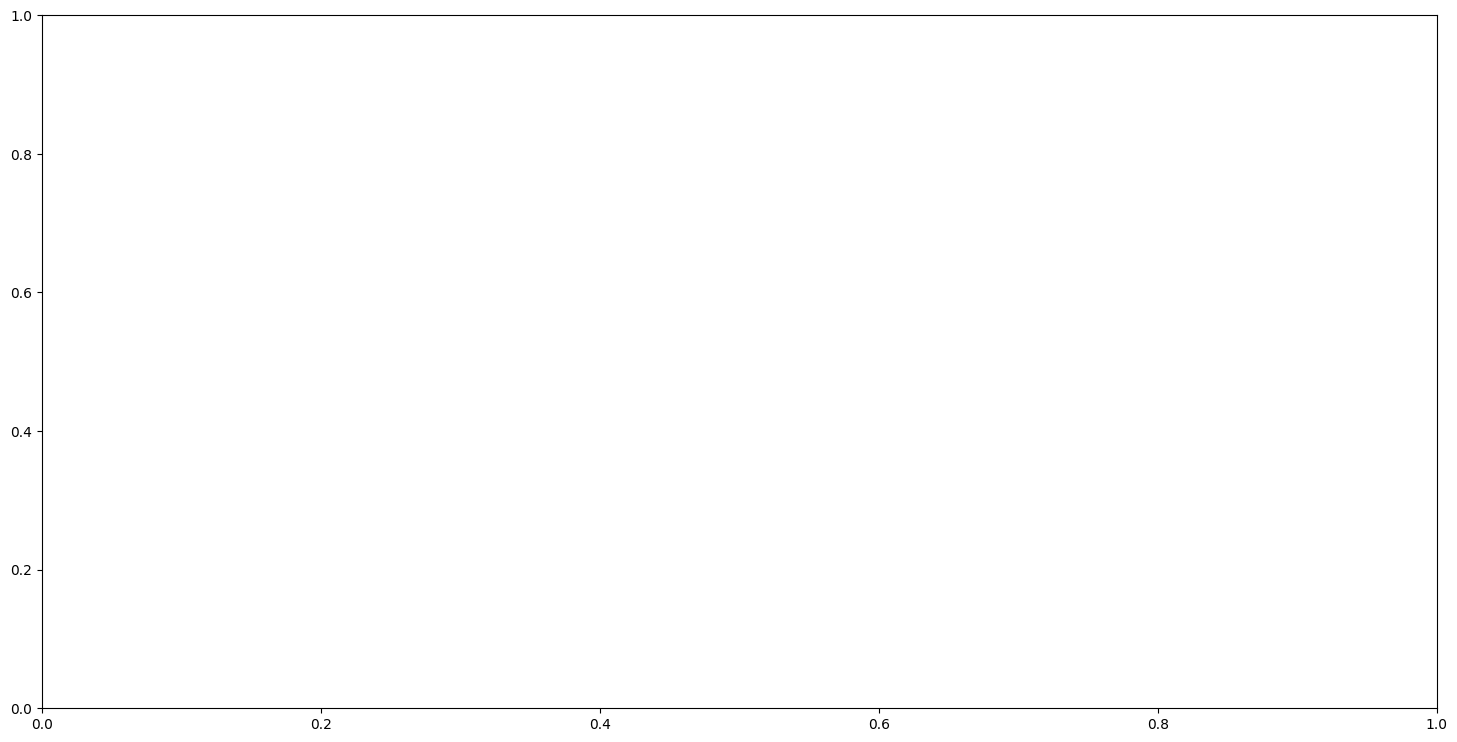

In [102]:
fig, ax = plt.subplots(figsize=(18,9))
ax.plot(amb_prof['time'].astype(str), amb_prof['q2'], color='orange')
ax.plot(amb_prof['time'].astype(str), amb_prof['q1'], color='teal')
ax.plot(amb_prof['time'].astype(str), amb_prof['q3'], color='teal')
ax.fill_between(amb_prof['time'].astype(str), amb_prof['q3'], amb_prof['q1'], alpha=0.2)
ax.plot(amb_prof['time'].astype(str), amb_prof['q10'], color='green', linestyle='dashed')
ax.plot(amb_prof['time'].astype(str), amb_prof['q90'], color='green', linestyle='dashed')

## LBGI experiment

Kovatchev BP, Cox DJ, Gonder-Frederick LA, Young-Hyman D, Schlundt D, Clarke WL: Assessment of risk for severe hypoglycemia among adults with IDDM: validation of the low blood glucose index. Diabetes Care  21 :1870 –1875, 1998

In [10]:
from datetime import timedelta

In [29]:
df = preprocessed_objects[0]['data']
df.dropna(inplace=True, subset=['glc'])

In [23]:
df.reset_index(drop=True, inplace=True)

In [43]:
df

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,2018-04-20 16:16:00,12.7,NaN
6,2018-04-20 16:31:00,13.1,NaN
...,...,...,...
21818,2017-10-23 18:58:00,2.6,NaN
21819,2017-10-23 19:13:00,2.2,NaN
21821,2017-10-23 19:28:00,2.2,NaN
21822,2017-10-23 19:44:00,2.2,NaN


In [47]:
df.set_index(['time'], inplace=True)

In [48]:
day = df.between_time('06:00','23:59')
night = df[~df.index.isin(day.index)]

In [49]:
day

,glc,scan_glc
time,,
2018-04-20 15:31:00,11.0,NaN
2018-04-20 15:46:00,11.5,NaN
2018-04-20 16:01:00,11.9,NaN
2018-04-20 16:16:00,12.7,NaN
2018-04-20 16:31:00,13.1,NaN
...,...,...
2017-10-23 18:58:00,2.6,NaN
2017-10-23 19:13:00,2.2,NaN
2017-10-23 19:28:00,2.2,NaN


In [50]:
night

,glc,scan_glc
time,,
2018-04-21 00:02:00,2.2,NaN
2018-04-21 00:17:00,2.2,NaN
2018-04-21 00:32:00,2.3,NaN
2018-04-21 00:47:00,2.7,NaN
2018-04-21 01:02:00,3.1,NaN
...,...,...
2017-10-23 04:56:00,2.2,NaN
2017-10-23 05:11:00,2.2,NaN
2017-10-23 05:26:00,2.2,NaN


In [65]:
def calc_bgi(glucose, mmol=True):
    if mmol:
        num1=1.794
        num2=1.026
        num3=1.861
    else:
        num1=1.509
        num2=1.084
        num3=5.381
    bgi = num1*(np.log(glucose)**num2 - num3)
    return bgi
    
def calc_lbgi(glucose, mmol=True):
    bgi = calc_bgi(glucose, mmol)
    lbgi = 10*(min(bgi, 0)**2)
    return lbgi

def calc_hbgi(glucose, mmol=True):
    bgi = calc_bgi(glucose, mmol)
    hbgi = 10*(max(bgi, 0)**2)
    return hbgi

def helper_bgi(df):
    lbgi = df['glc'].apply(lambda x: calc_lbgi(x)).mean()
    hbgi = df['glc'].apply(lambda x: calc_hbgi(x)).mean()
    return {'LBGI': lbgi, 'HBGI':hbgi}

In [70]:
helper_bgi(df)

{'LBGI': 2.979953584229811, 'HBGI': 6.99762682940931}

## Data sufficiency

In [31]:
df = preprocessed_objects[0]['data'].copy()
#df.dropna(subset=['glc', 'time'], inplace=True)

In [32]:
df

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
1,2018-04-20 15:35:00,NaN,10.8
2,2018-04-20 15:35:00,NaN,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
...,...,...,...
21822,2017-10-23 19:44:00,2.2,NaN
21823,2017-10-23 19:50:00,NaN,2.2
21824,2017-10-23 19:58:00,2.2,NaN
21825,2017-10-23 20:06:00,NaN,2.2


In [33]:
test1 = df.iloc[0:10]
#test1.iloc[2]['glc'] = np.nan

In [34]:
test1

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
1,2018-04-20 15:35:00,NaN,10.8
2,2018-04-20 15:35:00,NaN,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,2018-04-20 16:16:00,12.7,NaN
6,2018-04-20 16:31:00,13.1,NaN
7,2018-04-20 16:46:00,12.8,NaN
8,2018-04-20 17:01:00,12.8,NaN
9,2018-04-20 17:16:00,13.0,NaN


In [101]:
test3.to_csv('../tests/test-data/perc_missing_test3.csv')

In [36]:
helper_missing(test1, 15)

{'Start Time': '2018-04-20 15:31:00',
 'End Time': '2018-04-20 17:16:00',
 'Data Sufficiency': 100}

In [99]:
test2 = test1.copy()
test2.iloc[1]['glc'] = 10.8
test2.to_csv('../tests/test-data/perc_missing_test2.csv')

c:\Users\cr591\Anaconda3\envs\streamlit\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [97]:
test3 = test1.dropna(subset=['glc'])[['time', 'glc']].reset_index(drop=True)
test3['glc'].iloc[[3,7]]= np.nan


In [98]:
test3

,time,glc
0,2018-04-20 15:31:00,11.0
1,2018-04-20 15:46:00,11.5
2,2018-04-20 16:01:00,11.9
3,2018-04-20 16:16:00,12.7
4,2018-04-20 16:31:00,13.1
5,2018-04-20 16:46:00,12.8
6,2018-04-20 17:01:00,12.8
7,2018-04-20 17:16:00,13.0


,time,glc,scan_glc
3,2018-04-20 15:46:00,11.5,NaN
7,2018-04-20 16:46:00,12.8,NaN


In [92]:
test3['glc'].iloc[[3,7]]= np.nan

c:\Users\cr591\Anaconda3\envs\streamlit\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [93]:
test3

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
1,2018-04-20 15:35:00,NaN,10.8
2,2018-04-20 15:35:00,NaN,NaN
3,2018-04-20 15:46:00,NaN,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,2018-04-20 16:16:00,12.7,NaN
6,2018-04-20 16:31:00,13.1,NaN
7,2018-04-20 16:46:00,NaN,NaN
8,2018-04-20 17:01:00,12.8,NaN
9,2018-04-20 17:16:00,13.0,NaN


In [37]:
test1.dropna(subset=['time', 'glc'])

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,2018-04-20 16:16:00,12.7,NaN
6,2018-04-20 16:31:00,13.1,NaN
7,2018-04-20 16:46:00,12.8,NaN
8,2018-04-20 17:01:00,12.8,NaN
9,2018-04-20 17:16:00,13.0,NaN


In [58]:
((test1.time.iloc[-1] - test1.time.iloc[0])+timedelta(minutes=15))/+timedelta(minutes=15)

8.0

In [39]:
number_readings = sum(test1.set_index('time').groupby(pd.Grouper(freq='15min')).count()['glc'] > 0)


In [40]:
number_readings

8

In [53]:
number_readings = sum(test2.set_index('time').groupby(pd.Grouper(freq='15min')).count()['glc'] > 0)
number_readings

8

In [42]:
start_time = test1['time'].iloc[0]
end_time = test1['time'].iloc[-1]
time_diff = (end_time - start_time)
total_readings = time_diff.total_seconds() / (60 * 15)

In [76]:
test3.iloc[7]['glc'] = np.nan

In [77]:
test3

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
1,2018-04-20 15:35:00,NaN,10.8
2,2018-04-20 15:35:00,NaN,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,NaT,NaN,NaN
6,2018-04-20 16:31:00,13.1,NaN
7,NaT,NaN,NaN
8,2018-04-20 17:01:00,12.8,NaN
9,2018-04-20 17:16:00,13.0,NaN


In [72]:
test3.dropna(subset=['glc'])

,time,glc,scan_glc
0,2018-04-20 15:31:00,11.0,NaN
3,2018-04-20 15:46:00,11.5,NaN
4,2018-04-20 16:01:00,11.9,NaN
5,2018-04-20 16:16:00,12.7,NaN
6,2018-04-20 16:31:00,13.1,NaN
7,2018-04-20 16:46:00,12.8,NaN
8,2018-04-20 17:01:00,12.8,NaN
9,2018-04-20 17:16:00,13.0,NaN


In [66]:
helper_missing(test1, 15)

{'Start Time': '2018-04-20 15:31:00',
 'End Time': '2018-04-20 17:16:00',
 'Data Sufficiency': 100}

In [68]:
helper_missing(test2, 15)

{'Start Time': '2018-04-20 15:31:00',
 'End Time': '2018-04-20 17:16:00',
 'Data Sufficiency': 100}

In [94]:
helper_missing(test3, 15)

6


{'Start Time': '2018-04-20 15:31:00',
 'End Time': '2018-04-20 17:16:00',
 'Data Sufficiency': 75.0}

In [73]:
def helper_missing(df, gap_size): #, start_time, end_time
    """
    Helper for percent_missing function
    """
    # Calculate start and end time from dataframe
    start_time = df['time'].iloc[0]
    end_time = df['time'].iloc[-1]
    
    if gap_size == 5:
        freq = '5min'
    elif gap_size==15:
        freq = '15min'
    else:
        return print('EXPLODE THE PROGRAM')
    
    # calculate the number of non-null values
    number_readings = sum(df.set_index('time').groupby(pd.Grouper(freq=freq)).count()['glc'] > 0)
    # calculate the missing data based on start and end of df
    total_readings = ((end_time - start_time)+timedelta(minutes=gap_size))/+timedelta(minutes=gap_size)


    if number_readings >= total_readings:
        data_sufficiency = 100
    else:
        data_sufficiency = number_readings*100/total_readings
    
    return {'Start Time': str(start_time.round('min')), 'End Time':str(end_time.round('min')), 'Data Sufficiency':np.round(data_sufficiency, 1)}


In [10]:
helper_missing(df, 15)

{'Start Time': '2016-01-08 00:01:00',
 'End Time': '2018-12-09 23:54:00',
 'Data Sufficiency': 19.4}

In [5]:

df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)
df.reset_index(drop=True, inplace=True)
df.dropna(subset=['glc', 'time'], inplace=True)

In [39]:
df.time = df.time.apply(lambda x: x.timestamp())

In [42]:
df.describe()

,glc,scan_glc
count,19870.000000,0.0
mean,8.498440,NaN
std,3.667772,NaN
min,2.200000,NaN
25%,5.800000,NaN
50%,8.300000,NaN
75%,11.000000,NaN
max,27.800000,NaN


In [92]:
df.time

0       2018-04-20 15:31:00
3       2018-04-20 15:46:00
4       2018-04-20 16:01:00
5       2018-04-20 16:16:00
6       2018-04-20 16:31:00
                ...        
21818   2017-10-23 18:58:00
21819   2017-10-23 19:13:00
21821   2017-10-23 19:28:00
21822   2017-10-23 19:44:00
21824   2017-10-23 19:58:00
Name: time, Length: 19870, dtype: datetime64[ns]

In [31]:
df.time.values.astype(float)

array([1.45221126e+09, 1.45221216e+09, 1.45221306e+09, ...,
       1.54439784e+09, 1.54439874e+09, 1.54439964e+09])

In [37]:
df

,time,glc,scan_glc
0,1970-01-01 00:00:01.452211260,3.6,NaN
1,1970-01-01 00:00:01.452212160,3.1,NaN
2,1970-01-01 00:00:01.452213060,2.3,NaN
3,1970-01-01 00:00:01.452213960,2.2,NaN
4,1970-01-01 00:00:01.452214860,2.2,NaN
...,...,...,...
21822,1970-01-01 00:00:01.544396340,NaN,NaN
21823,1970-01-01 00:00:01.544396940,4.9,NaN
21824,1970-01-01 00:00:01.544397840,5.7,NaN
21825,1970-01-01 00:00:01.544398740,5.2,NaN


## AUC

https://www.researchgate.net/publication/5552064_A_Novel_Strategy_in_Production_of_Oligosaccharides_in_Digestive_Tract_Prevention_of_Postprandial_Hyperglycemia_and_Hyperinsulinemia/figures?lo=1

In [5]:
df = preprocessed_objects[0]['data']
df = df.dropna(subset=['time', 'glc']).sort_values('time').reset_index(drop=True)

NameError: name 'preprocessed_objects' is not defined

In [4]:
df = example3
df.time = pd.to_datetime(df.time)

In [9]:
def calculate_auc(df):
    if df.shape[0]>1:
        start_time = df.time.iloc[0]
        mins_from_start = df.time.apply(lambda x: x-start_time)
        df['hours_from_start'] = mins_from_start.apply(lambda x: (x.total_seconds()/60)/60)
        avg_auc = auc(df['hours_from_start'], df['glc'])#/24
        return avg_auc
    else:
        return np.nan

def auc_helper(df):
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    hourly_breakdown = df.groupby([df.date, df.hour]).apply(lambda group: calculate_auc(group)).reset_index()
    hourly_breakdown.columns = ['date', 'hour', 'auc']
    daily_breakdown = hourly_breakdown.groupby('date').auc.mean()
    hourly_avg = hourly_breakdown.auc.mean()
    #daily_auc = df.groupby(df['time'].dt.date).apply(lambda group: calculate_auc(group))/24 # .reset_index()
    #daily_avg = daily_auc.mean()
    return  hourly_avg, daily_breakdown, hourly_breakdown 

In [12]:
daily_breakdown

date
2020-01-13    3.199479
2020-01-14    2.885417
2020-01-15    3.111979
2020-01-16    3.252083
2020-01-17    3.518750
2020-01-18    3.323438
2020-01-19    3.289583
2020-01-20    3.634375
2020-01-21    3.554167
2020-01-22    3.240625
2020-01-23    3.658333
2020-01-24    2.520833
2020-10-01    1.993182
2020-11-01    2.630208
2020-12-01    3.450000
Name: auc, dtype: float64

In [10]:
hourly_avg, daily_breakdown, hourly_breakdown  = auc_helper(df)

         date  hour     auc
0  2020-01-13     0  4.1250
1  2020-01-13     1  4.2000
2  2020-01-13     2  4.5500
3  2020-01-13     3  4.4625
4  2020-01-13     4  3.9125
3.2246234939759035


In [5]:
def calculate_auc(df):
    if df.shape[0]>1:
        start_time = df.time.iloc[0]
        mins_from_start = df.time.apply(lambda x: x-start_time)
        df['hours_from_start'] = mins_from_start.apply(lambda x: (x.total_seconds()/60)/60)
        avg_auc = auc(df['hours_from_start'], df['glc'])#/24
        return avg_auc
    else:
        return np.nan

In [6]:
def calculate_auc(df):
    hourly_breakdown = df.groupby([df['time'].dt.date, df['time'].dt.hour]).apply(lambda group: calculate_auc(group))#.reset_index()
    
    # Hacking the weird groupby index labelling
    hourly_breakdown = hourly_breakdown.reset_index(level=1)
    hourly_breakdown.columns = ['hour', 'auc']
    hourly_breakdown = hourly_breakdown.reset_index()
    hourly_breakdown.columns = ['date', 'hour', 'auc']
    daily_breakdown = hourly_breakdown.groupby('date').auc.mean()

    hourly_avg = hourly_breakdown.auc.mean()
    #daily_auc = df.groupby(df['time'].dt.date).apply(lambda group: calculate_auc(group))/24 # .reset_index()
    #daily_avg = daily_auc.mean()
    return hourly_avg, daily_breakdown, hourly_breakdown 

In [10]:
hourly_avg,  hourly_breakdown = calculate_auc(df)

: 

: 

In [7]:
datimeshiz = df.groupby([df['time'].dt.date, df['time'].dt.hour]).apply(lambda group: calculate_daily_auc(group))#.reset_index()

NameError: name 'calculate_daily_auc' is not defined

In [48]:
datimeshiz = datimeshiz.reset_index(level=0)
datimeshiz.columns = ['date', 'auc']
datimeshiz = datimeshiz.reset_index(level=0)


In [49]:
datimeshiz

,time,date,auc
0,0,2020-01-13,4.1250
1,1,2020-01-13,4.2000
2,2,2020-01-13,4.5500
3,3,2020-01-13,4.4625
4,4,2020-01-13,3.9125
5,5,2020-01-13,3.8375
6,6,2020-01-13,3.5375
7,7,2020-01-13,3.6500
8,8,2020-01-13,3.2875
9,9,2020-01-13,3.2750


In [25]:
hourly_auc = df.groupby(df['time'].dt.hour).apply(lambda group: calculate_daily_auc(group)).reset_index()


ValueError: x is neither increasing nor decreasing : [ 0.00000e+00  2.50000e-01  5.00000e-01  7.50000e-01  7.20000e+02
  7.20250e+02  7.20500e+02  7.20750e+02 -7.03200e+03 -7.03175e+03
 -7.03150e+03 -7.03125e+03 -7.00800e+03 -7.00775e+03 -7.00750e+03
 -7.00725e+03 -6.98400e+03 -6.98375e+03 -6.98350e+03 -6.98325e+03
 -6.96000e+03 -6.95975e+03 -6.95950e+03 -6.95925e+03 -6.93600e+03
 -6.93575e+03 -6.93550e+03 -6.93525e+03 -6.91200e+03 -6.91175e+03
 -6.91150e+03 -6.91125e+03 -6.88800e+03 -6.88775e+03 -6.88750e+03
 -6.88725e+03 -6.86400e+03 -6.86375e+03 -6.86350e+03 -6.86325e+03
 -6.84000e+03 -6.83975e+03 -6.83950e+03 -6.83925e+03 -6.81600e+03
 -6.81575e+03 -6.81550e+03 -6.81525e+03 -6.79200e+03 -6.79175e+03
 -6.79150e+03 -6.79125e+03 -6.76800e+03 -6.76775e+03 -6.76750e+03
 -6.76725e+03].

In [23]:
dailyauc = calculate_auc(df)

In [24]:
dailyauc

,time,0
0,2020-01-13,4.209375
1,2020-01-14,3.804688
2,2020-01-15,4.095833
3,2020-01-16,4.269792
4,2020-01-17,4.633333
5,2020-01-18,4.391146
6,2020-01-19,4.356250
7,2020-01-20,4.784896
8,2020-01-21,4.682292
9,2020-01-22,4.253646


In [24]:
newdf

,time,glc,scan_glc,diff,mins_from_start
12675,2016-01-08 00:01:00,3.6,NaN,-206 days +00:15:00,0 days 00:00:00
12676,2016-01-08 00:16:00,3.1,NaN,0 days 00:15:00,0 days 00:15:00
12677,2016-01-08 00:31:00,2.3,NaN,0 days 00:15:00,0 days 00:30:00
12678,2016-01-08 00:46:00,2.2,NaN,0 days 00:15:00,0 days 00:45:00
12679,2016-01-08 01:01:00,2.2,NaN,0 days 00:15:00,0 days 01:00:00
...,...,...,...,...,...
11393,2018-12-09 22:54:00,3.1,NaN,0 days 00:14:00,1066 days 22:53:00
11396,2018-12-09 23:09:00,4.9,NaN,0 days 00:15:00,1066 days 23:08:00
11397,2018-12-09 23:24:00,5.7,NaN,0 days 00:15:00,1066 days 23:23:00
11398,2018-12-09 23:39:00,5.2,NaN,0 days 00:15:00,1066 days 23:38:00


In [30]:
newdf['mins_from_start'].apply(lambda x: (x.total_seconds()/60)/60)

12675        0.000000
12676        0.250000
12677        0.500000
12678        0.750000
12679        1.000000
             ...     
11393    25606.883333
11396    25607.133333
11397    25607.383333
11398    25607.633333
11399    25607.883333
Name: mins_from_start, Length: 19870, dtype: float64

time
2016-01-08    {'ID': '1', 'Average glucose': 5.0645833333333...
2016-01-10    {'ID': '1', 'Average glucose': 2.6545454545454...
2016-02-08    {'ID': '1', 'Average glucose': 6.3168421052631...
2016-02-10    {'ID': '1', 'Average glucose': 9.4000000000000...
2016-03-08    {'ID': '1', 'Average glucose': 8.2263157894736...
                                    ...                        
2018-11-09    {'ID': '1', 'Average glucose': 9.7083333333333...
2018-12-06    {'ID': '1', 'Average glucose': 7.0347826086956...
2018-12-07    {'ID': '1', 'Average glucose': 5.6645833333333...
2018-12-08    {'ID': '1', 'Average glucose': 8.9927083333333...
2018-12-09    {'ID': '1', 'Average glucose': 8.8989583333333...
Length: 236, dtype: object

In [46]:
auc(df.time.values.astype(float), df.glc.values)

714733344.0

In [45]:
auc(df.time, df.glc)

UFuncTypeError: Cannot cast ufunc 'less' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [4]:
dict_results = []
for i in preprocessed_objects:
    if i.usable==True:
        df_id = i.data
        results = metrics_experiment.calculate_all_metrics(df_id, ID=i.id, unit=i.units, interval=i.interval)
        dict_results.append(results)

In [5]:
pd.DataFrame.from_dict(dict_results)

,ID,Average glucose,SD,CV,eA1c,TIR normal,TIR hypoglycaemia,tir_lv1_hypo,tir_lv2_hypo,tir_hyper,tir_lv1_hyper,tir_lv2_hyper,total_number_hypos,number_lv1_hypos,number_lv2_hypos,avg_length_of_hypo,total_time_in_hypos
0,3028,8.49844,3.667772,43.158179,6.973862,55.81,11.11,4.98,6.13,33.07,25.37,7.71,308,131,177,0 days 14:04:17,180 days 13:59:00
1,3028 2,8.49844,3.667772,43.158179,6.973862,55.81,11.11,4.98,6.13,33.07,25.37,7.71,308,131,177,0 days 14:04:17,180 days 13:59:00


In [8]:
pd.DataFrame(dict_results)

,avg,sd,cv,id
0,8.49844,3.667772,43.158179,3028
1,8.49844,3.667772,43.158179,3028 2


In [7]:
metrics.time_in_range(total_df)

,ID,tir_norm,tir_hypo,tir_lv1_hypo,tir_lv2_hypo,tir_hyper,tir_lv1_hyper,tir_lv2_hyper
0,3028,55.81,11.11,4.98,6.13,33.07,25.37,7.71
1,3028 2,55.81,11.11,4.98,6.13,33.07,25.37,7.71


In [13]:
result_metrics = pd.DataFrame()
for i in preprocessed_objects:
    if i.usable==True:
        tir = metrics.time_in_range(i.data)
        tir['ID'] = i.id
    else:
        #log something


NameError: name 'metrics' is not defined

In [12]:
total_df

,time,glc,scan_glc,ID
0,2018-04-20 15:31:00,11.0,NaN,3028
1,2018-04-20 15:35:00,NaN,10.8,3028
2,2018-04-20 15:35:00,NaN,NaN,3028
3,2018-04-20 15:46:00,11.5,NaN,3028
4,2018-04-20 16:01:00,11.9,NaN,3028
...,...,...,...,...
21820,2017-10-23 18:58:00,2.6,NaN,3028 2
21821,2017-10-23 19:13:00,2.2,NaN,3028 2
21823,2017-10-23 19:28:00,2.2,NaN,3028 2
21824,2017-10-23 19:44:00,2.2,NaN,3028 2


In [ ]:
person1 = checkDevices.checkDevices(example1)

hello


c:\Users\cr591\Anaconda3\envs\streamlit\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [3]:
person2 = checkDevices.checkDevices(example2)

hello


In [4]:
uk_data = person2.data
us_data = person2.data

In [5]:
us_data['glc'] = us_data['glc']/0.0557

TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [4]:
person1.data

,time,glc,scan_glc
0,20-04-2018 15:31,11.0,NaN
1,20-04-2018 15:35,NaN,10.8
2,20-04-2018 15:35,NaN,NaN
3,20-04-2018 15:46,11.5,NaN
4,20-04-2018 16:01,11.9,NaN
...,...,...,...
21822,23-10-2017 19:44,2.2,NaN
21823,23-10-2017 19:50,NaN,2.2
21824,23-10-2017 19:58,2.2,NaN
21825,23-10-2017 20:06,NaN,2.2


In [30]:
if pd.notnull(example1.iloc[0,2]):
    print('booo')

In [27]:
if example1.iloc[0,2]:
    print('booo')

booo


In [10]:
header =['Meter',	'Serial Number',	'Meter Timestamp',	'Record Type',	'Historic Glucose(mmol/L)',	'Scan Glucose(mmol/L)']


In [16]:
print(set(example1.iloc[1]))

{nan, 'Scan Glucose(mmol/L)', 'Correction Insulin (units)', 'Historic Glucose(mmol/L)', 'Rapid-Acting Insulin (units)', 'Non-numeric Rapid-Acting Insulin', 'Long-Acting Insulin (units)', 'Serial Number', 'Notes', 'Carbohydrates (servings)', 'Ketone(mmol/L)', 'Record Type', 'Carbohydrates (grams)', 'Non-numeric Long-Acting Insulin', 'Non-numeric Food', 'Meter', 'User Change Insulin (units)', 'Strip Glucose(mmol/L)', 'Meter Timestamp', 'Meal Insulin (units)'}


In [17]:
if set(header).issubset(set(example1.iloc[1])):
    print('booo')

booobs


In [5]:
example1.count().max()

21829

In [3]:
preprocessing.preprocess_data(example1)

{'dt': ['14-09-2018'], 'glc_uk': ['Robert Andrews'], 'glc_us': []}


,time,glc
0,20-04-2018 15:31,11.0
1,20-04-2018 15:46,11.5
2,20-04-2018 16:01,11.9
3,20-04-2018 16:16,12.7
4,20-04-2018 16:31,13.1
...,...,...
19865,23-10-2017 18:58,2.6
19866,23-10-2017 19:13,2.2
19867,23-10-2017 19:28,2.2
19868,23-10-2017 19:44,2.2
